In [1943]:
%matplotlib inline
import sys
sys.path.insert(0, '../')

import random
import glob
import os
from PIL import Image
import torch
import torchvision
from torch.autograd import Variable
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

def show(img):
    npimg = img.numpy()
    npimg = ((npimg / 2.0) + 0.5) * 255.0
    npimg = npimg.astype(np.uint8)
    plt.figure(figsize = (20,20))
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

import util.util as util
from models import networks
from options.test_options import TestOptions

def load_network_with_path(network, network_label, epoch_label='latest', path='./checkpoints/danbooru_celeba_cyclegan/'):
    save_filename = '%s_net_%s.pth' % (epoch_label, network_label)
    save_path = os.path.join(path, save_filename)
    network.load_state_dict(torch.load(save_path))

def get_trans(crop=None, size=None):
    transform_list_show = []
    transform_list = []
    if crop is not None:
        opt.loadSize = crop
    if size is not None:
        opt.fineSize = size
    osize = [opt.loadSize, opt.loadSize]
    transform_list_show += [transforms.Scale(osize, Image.BICUBIC),
                       transforms.RandomCrop(opt.fineSize),
                       transforms.ToTensor()]
    img_show = transforms.Compose(transform_list_show)
    transform_list = transform_list_show + [transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))]
    img_pre = transforms.Compose(transform_list)
    return img_show, img_pre    

def to_input(img, trans, size):
    img = trans(img)
    input_ = img.view(-1, 3, size, size)
    real = Variable(input_.cuda())
    return real

def test_img(img, net, trans, size, eval_mode=False):
    img = trans(img)
    input_ = img.view(-1, 3, size, size)
    real = Variable(input_.cuda())
    if eval_mode:
        net.eval()
    else:
        net.train()
    fake = net.forward(real)
    return fake

def get_stack_nets(path, which_epoch = 'latest'):
    gpu_ids = [0]
    Tensor = torch.cuda.FloatTensor
    netG_A = networks.define_G(opt.input_nc, opt.output_nc,
                            opt.ngf, opt.which_model_netG, opt.norm, False, opt.init_type, 
                            gpu_ids, n_upsampling=3, opt=opt)
    netG_B = networks.define_G(opt.output_nc, opt.input_nc,
                            opt.ngf, opt.which_model_netG, opt.norm, False, opt.init_type, 
                            gpu_ids, n_upsampling=3, opt=opt)
    netG_A_pre = networks.define_G(opt.input_nc, opt.output_nc,
                            opt.ngf, opt.which_model_netG, opt.norm, False, opt.init_type, 
                            gpu_ids, n_downsampling=3, opt=opt)
    netG_B_pre = networks.define_G(opt.output_nc, opt.input_nc,
                            opt.ngf, opt.which_model_netG, opt.norm, False, opt.init_type, 
                            gpu_ids, n_downsampling=3, opt=opt)

    load_network_with_path(netG_A,  'G_A', which_epoch, path)
    load_network_with_path(netG_B,  'G_B', which_epoch, path)
    load_network_with_path(netG_A_pre,  'G_A_pre', which_epoch, path)
    load_network_with_path(netG_B_pre,  'G_B_pre', which_epoch, path)
        
    netG_A.cuda()
    netG_B.cuda()
    netG_A_pre.cuda()
    netG_B_pre.cuda()
    
    return {'A':netG_A, 'B':netG_B, 'A_pre':netG_A_pre, 'B_pre':netG_B_pre}

def get_nets(path, which_epoch = 'latest'):
    gpu_ids = [0]
    Tensor = torch.cuda.FloatTensor
    opt = util.load_opt(path)

    netG_A = networks.define_G(opt.input_nc, opt.output_nc,
                                  opt.ngf, opt.which_model_netG,
                                  opt.norm, True, opt.init_type,
                                  gpu_ids, opt=opt)
    load_network_with_path(netG_A, 'G_A', which_epoch, path)
    
    netG_B = networks.define_G(opt.input_nc, opt.output_nc,
                                  opt.ngf, opt.which_model_netG,
                                  opt.norm, True, opt.init_type,
                                  gpu_ids, opt=opt)
    load_network_with_path(netG_B, 'G_B', which_epoch, path)
    
    netD_A = networks.define_D(opt.input_nc, opt.ndf,
                               opt.which_model_netD, opt.n_layers_D,
                                  opt.norm, False, opt.init_type,
                                  gpu_ids, opt=opt)
    load_network_with_path(netD_A, 'D_A', which_epoch, path)
    
    netD_B = networks.define_D(opt.input_nc, opt.ndf,
                               opt.which_model_netD, opt.n_layers_D,
                                  opt.norm, False, opt.init_type,
                                  gpu_ids, opt=opt)
    load_network_with_path(netD_B, 'D_B', which_epoch, path)
    
    netG_A.cuda()
    netG_B.cuda()
    netD_A.cuda()
    netD_B.cuda()
    
    return {'A':netG_A, 'B':netG_B, 'D_A':netD_A, 'D_B':netD_B}

opt = TestOptions().parse()
opt.nThreads = 1   # test code only supports nThreads = 1
opt.batchSize = 1  # test code only supports batchSize = 1
opt.serial_batches = True  # no shuffle
opt.no_flip = True  # no flip

------------ Options -------------
alpha_gate: 
aspect_ratio: 1.0
batchSize: 1
checkpoints_dir: ./checkpoints
dataroot: ./datasets/danbooru_celeba
dataset_mode: unaligned
f: /run/user/1001/jupyter/kernel-7f2188b6-872a-4651-bd8b-20bb375d80d4.json
feat_len_D: 256
feat_only: False
fineSize: 256
gpu_ids: [0]
how_many: inf
img_2ngf: False
img_only: False
init_type: xavier
input_nc: 3
isTrain: False
keep_pre: False
kw: 3
legacy_D: False
loadSize: 286
load_pre: False
lr_pre: 2e-05
max_dataset_size: inf
max_ngf: 256
model: cycle_gan
nThreads: 2
n_downsample: 2
n_layers_D: 3
n_layers_D_pre: 3
n_resblocks: 9
n_upsample: 2
name: experiment_name
ndf: 64
ngf: 64
no_dropout: False
no_flip: False
norm: instance
not_mono_gate: False
ntest: inf
one_out: False
out7: False
out_num: 3
output_nc: 3
phase: test
pre_path: 
resize_or_crop: resize_and_crop
results_dir: ./results/
serial_batches: False
shallow_resblock: False
shift_alpha: False
simple_block: False
skip: False
skip_feat: False
stage: 2
test: Fal

In [2251]:
opt.dataroot = '../datasets/getchu_celeba_aligned_cleaned_v1/'
phase = 'train'
B_path = glob.glob(os.path.join(opt.dataroot,phase+'B/*'))
A_path = glob.glob(os.path.join(opt.dataroot,phase+'A/*'))
# AB_path = glob.glob(os.path.join(opt.dataroot,phase+'/*')) 
# Ext_path = glob.glob('../../../../DataTang_Extra/*.jpg')

img_show, img_pre = get_trans()
img_show_64, img_pre_64 = get_trans(64, 64)
img_show_128, img_pre_128 = get_trans(128, 128)
img_show_256, img_pre_256 = get_trans(256, 256)

net_0 = get_nets('../../trans/Get_Cel_Ali_Cln_128_d4_gpreweight_1/')
net_1 = get_nets('../checkpoints/Get_Cel_Ali_Cln_128_def_0/')
net_2 = get_nets('../checkpoints/Get_Cel_Ali_Cln_128_3D_weight_0/')
net_3 = get_nets('../checkpoints/Get_Cel_Ali_Cln_128_3D_weight_1/')
net_4 = get_nets('../../trans/Get_Cel_Ali_Cln_ORIG_128/')
net_5 = get_nets('../checkpoints/Get_Cel_Ali_Cln_128_def_long/')

initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]


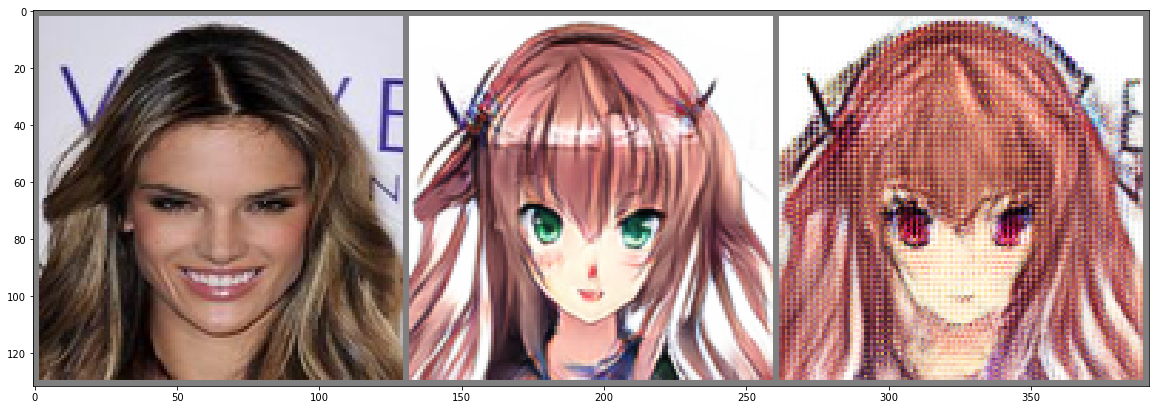

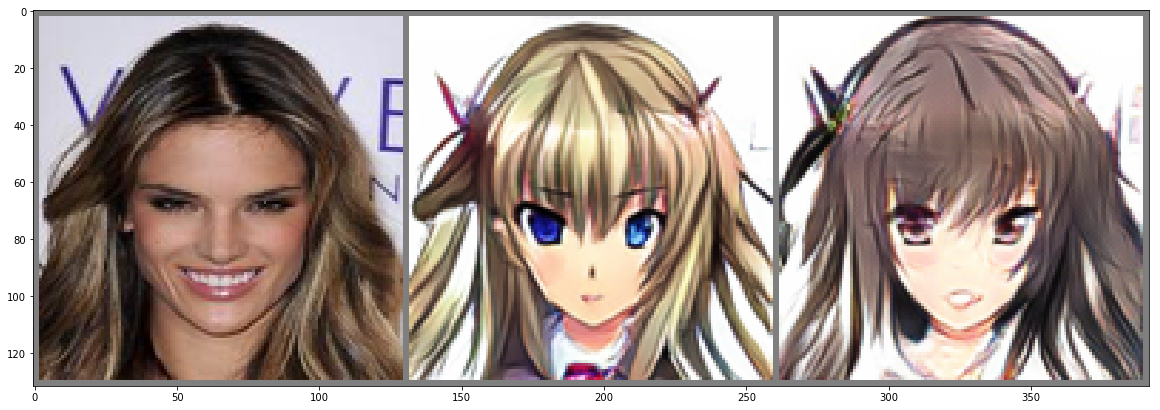

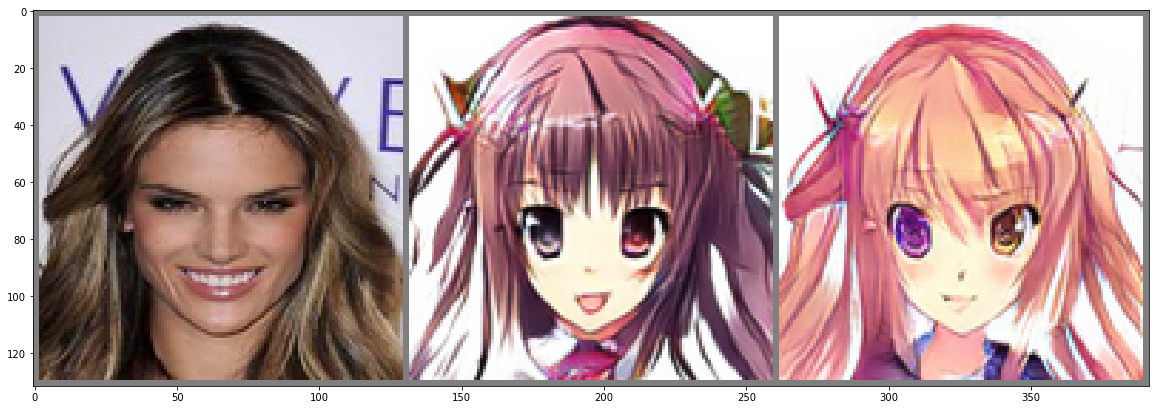

In [2267]:
B_p = random.choice(B_path)
# B_p = './datasets/horse2zebra/trainB/n02391049_10596.jpg'
B_ = Image.open(B_p).convert('RGB').resize((128,128),Image.LANCZOS)
fake_A_0 = test_img(B_, net_0['B'], img_pre_128, 128, eval_mode=True)
fake_A_1 = test_img(B_, net_1['B'], img_pre_128, 128, eval_mode=True)
fake_A_2 = test_img(B_, net_2['B'], img_pre_128, 128, eval_mode=True)
fake_A_3 = test_img(B_, net_3['B'], img_pre_128, 128, eval_mode=True)
fake_A_4 = test_img(B_, net_4['B'], img_pre_128, 128, eval_mode=True)
fake_A_5 = test_img(B_, net_5['B'], img_pre_128, 128, eval_mode=True)

show(torchvision.utils.make_grid([img_pre_128(B_),fake_A_0.data[0].cpu(),fake_A_2.data[0].cpu()]))
show(torchvision.utils.make_grid([img_pre_128(B_),fake_A_5.data[0].cpu(),fake_A_3.data[0].cpu()]))
show(torchvision.utils.make_grid([img_pre_128(B_),fake_A_1.data[0].cpu(),fake_A_4.data[0].cpu()]))

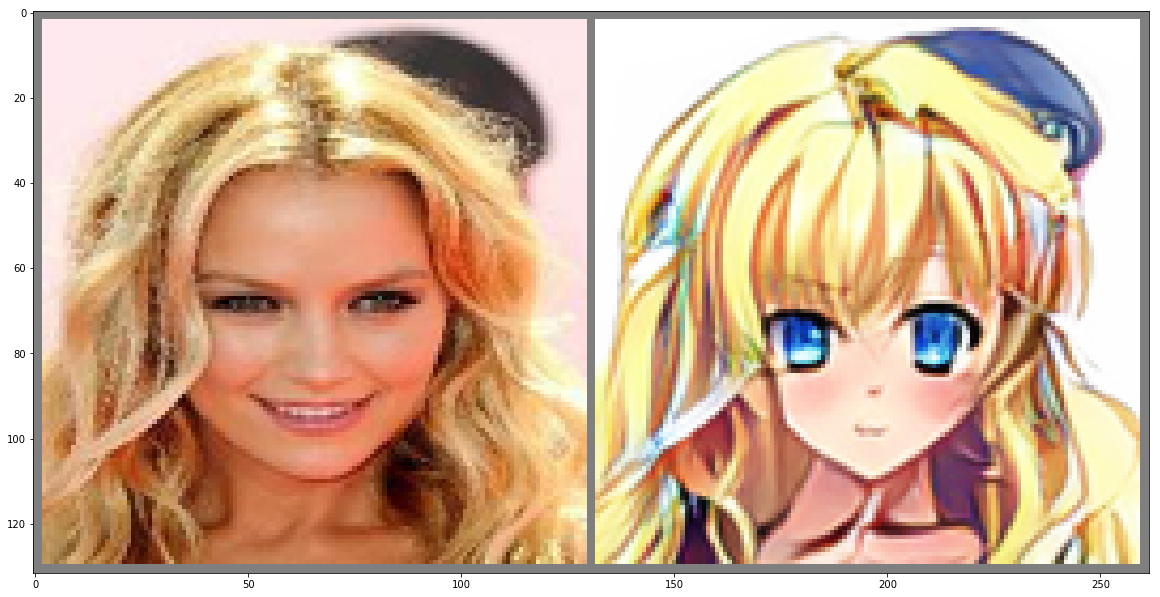

In [2055]:
show(torchvision.utils.make_grid([img_pre_128(B_),fake_A_5.data[0].cpu()]))

In [2582]:
opt.dataroot = '../datasets/getchu_aisa_aligned_cleaned_v1/'
phase = 'train'
B_path = glob.glob(os.path.join(opt.dataroot,phase+'B/*'))
A_path = glob.glob(os.path.join(opt.dataroot,phase+'A/*'))
# AB_path = glob.glob(os.path.join(opt.dataroot,phase+'/*'))
# Ext_path = glob.glob('../../../../DataTang_Extra/*.jpg')

img_show, img_pre = get_trans()
img_show_64, img_pre_64 = get_trans(64, 64)
img_show_128, img_pre_128 = get_trans(128, 128)
img_show_256, img_pre_256 = get_trans(256, 256)

net_0 = get_nets('../../trans/Get_Cel_Ali_Cln_128_d4_gpreweight_1/')
net_1 = get_nets('../checkpoints/Get_Cel_Ali_Cln_128_def_0/')
net_2 = get_nets('../checkpoints/Get_Ais_128_d4_gpreweight_0/')
net_3 = get_nets('../checkpoints/Get_Ais_128_d4_gpreweight_1/')
net_4 = get_nets('../../trans/Get_Cel_Ali_Cln_128_prog_1/')
net_5 = get_nets('../checkpoints/Get_Cel_Ali_Cln_128_def_long/')
net_6 = get_nets('../../trans/Get_AisCel_128_d4_gpreweight_0/')
net_7 = get_nets('../../trans/Get_AisCel_128_d4_gpreweight_1/')
# net_8 = get_nets('../../trans/Get_AisCel_128_d4_gpreweight_0/')
# net_9 = get_nets('../../trans/Get_AisCel_128_d4_gpreweight_1/')

initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]
initialization method [xavier]


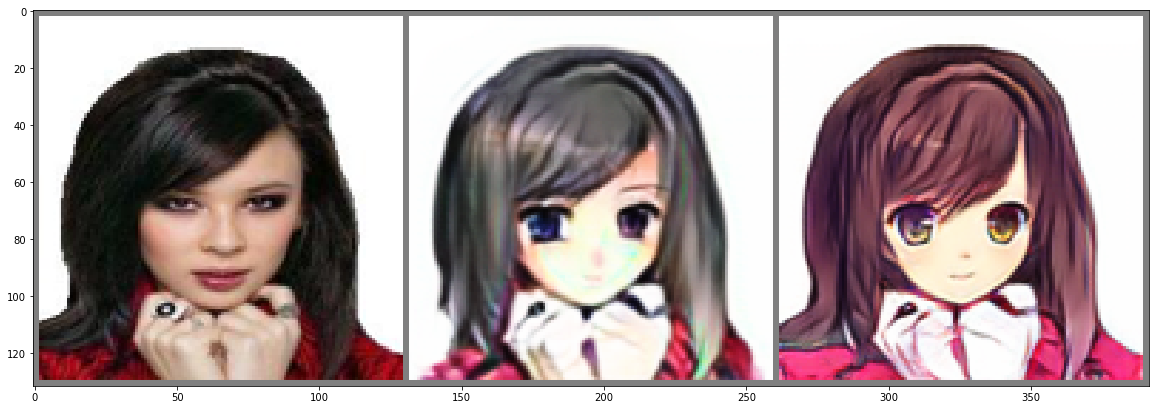

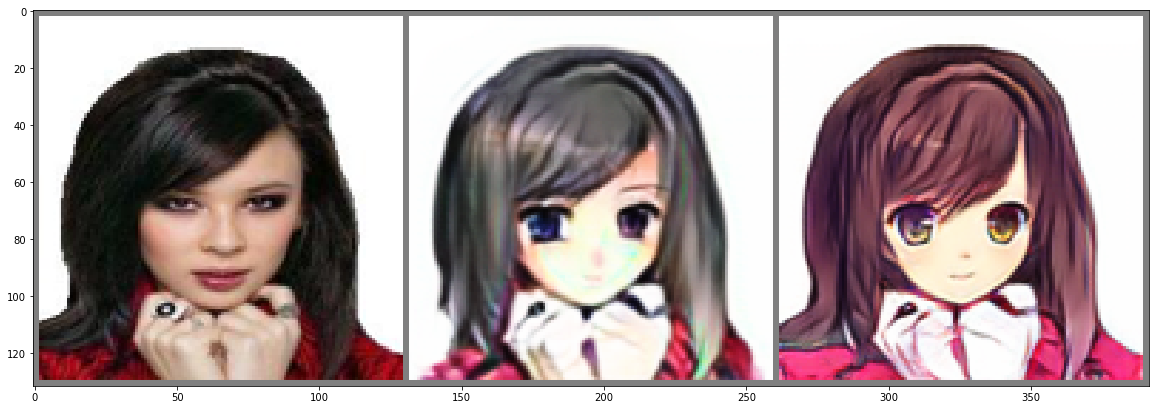

In [2587]:
B_p = random.choice(B_mat_path)
# B_p = './datasets/horse2zebra/trainB/n02391049_10596.jpg'
B_ = Image.open(B_p).convert('RGB')
fake_A_0 = test_img(B_, net_0['B'], img_pre_128, 128, eval_mode=True)
fake_A_1 = test_img(B_, net_1['B'], img_pre_128, 128, eval_mode=True)
fake_A_2 = test_img(B_, net_2['B'], img_pre_128, 128, eval_mode=True)
fake_A_3 = test_img(B_, net_3['B'], img_pre_128, 128, eval_mode=True)
fake_A_4 = test_img(B_, net_4['B'], img_pre_128, 128, eval_mode=True)
fake_A_5 = test_img(B_, net_5['B'], img_pre_128, 128, eval_mode=True)
fake_A_6 = test_img(B_, net_6['B'], img_pre_128, 128, eval_mode=True)
fake_A_7 = test_img(B_, net_7['B'], img_pre_128, 128, eval_mode=True)
fake_A_8 = test_img(B_, net_8['B'], img_pre_128, 128, eval_mode=True)
fake_A_9 = test_img(B_, net_9['B'], img_pre_128, 128, eval_mode=True)

# show(torchvision.utils.make_grid([img_pre_128(B_),fake_A_0.data[0].cpu(),fake_A_1.data[0].cpu()]))
# show(torchvision.utils.make_grid([img_pre_128(B_),fake_A_2.data[0].cpu(),fake_A_3.data[0].cpu()]))
#show(torchvision.utils.make_grid([img_pre_128(B_),fake_A_4.data[0].cpu(),fake_A_5.data[0].cpu()]))
show(torchvision.utils.make_grid([img_pre_128(B_),fake_A_6.data[0].cpu(),fake_A_7.data[0].cpu()]))
show(torchvision.utils.make_grid([img_pre_128(B_),fake_A_8.data[0].cpu(),fake_A_9.data[0].cpu()]))

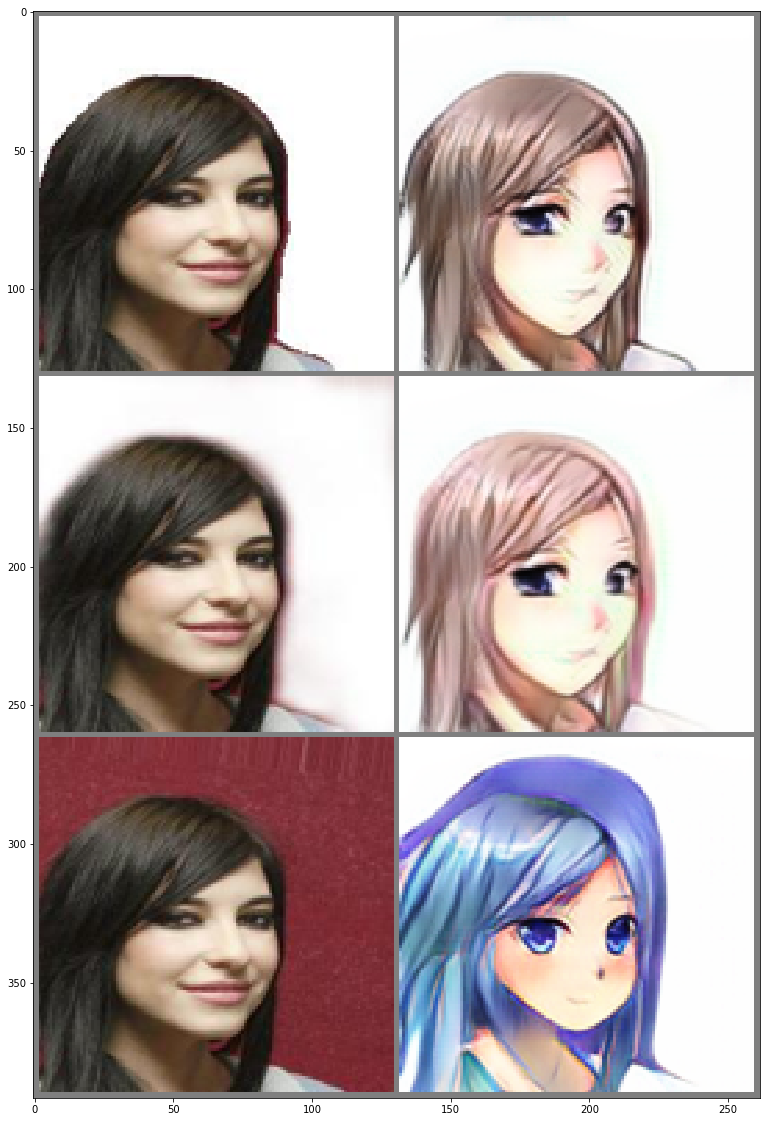

In [2689]:
B_p = random.choice(B_mat_path)
B_crop_path = os.path.join(cropped_root, B_p.split('/')[-1])
B_blur_path = os.path.join(blur_root, B_p.split('/')[-1])
# B_p = './datasets/horse2zebra/trainB/n02391049_10596.jpg'
B_ = Image.open(B_p).convert('RGB')
B_crop = Image.open(B_crop_path).convert('RGB')
B_blur = Image.open(B_blur_path).convert('RGB')
fake_A_8 = test_img(B_, net_8['B'], img_pre_128, 128, eval_mode=True)
fake_A_8_c = test_img(B_crop, net_8['B'], img_pre_128, 128, eval_mode=True)
fake_A_8_b = test_img(B_blur, net_8['B'], img_pre_128, 128, eval_mode=True)

# show(torchvision.utils.make_grid([img_pre_128(B_),fake_A_0.data[0].cpu(),fake_A_1.data[0].cpu()]))
# show(torchvision.utils.make_grid([img_pre_128(B_),fake_A_8.data[0].cpu(),fake_A_0.data[0].cpu(), img_pre_128(B_crop),fake_A_8_c.data[0].cpu(),fake_A_0_c.data[0].cpu()], nrow=3))
show(torchvision.utils.make_grid([img_pre_128(B_),fake_A_8.data[0].cpu(), img_pre_128(B_blur),fake_A_8_b.data[0].cpu(),img_pre_128(B_crop),fake_A_8_c.data[0].cpu()], nrow=2))
# show(torchvision.utils.make_grid([img_pre_128(B_crop),fake_A_0_c.data[0].cpu(),fake_A_1_c.data[0].cpu()]))
# show(torchvision.utils.make_grid([img_pre_128(B_crop),fake_A_8_c.data[0].cpu(),fake_A_9_c.data[0].cpu()]))

In [2668]:
B_p

'/data2/minjunli/B/008549.jpg'

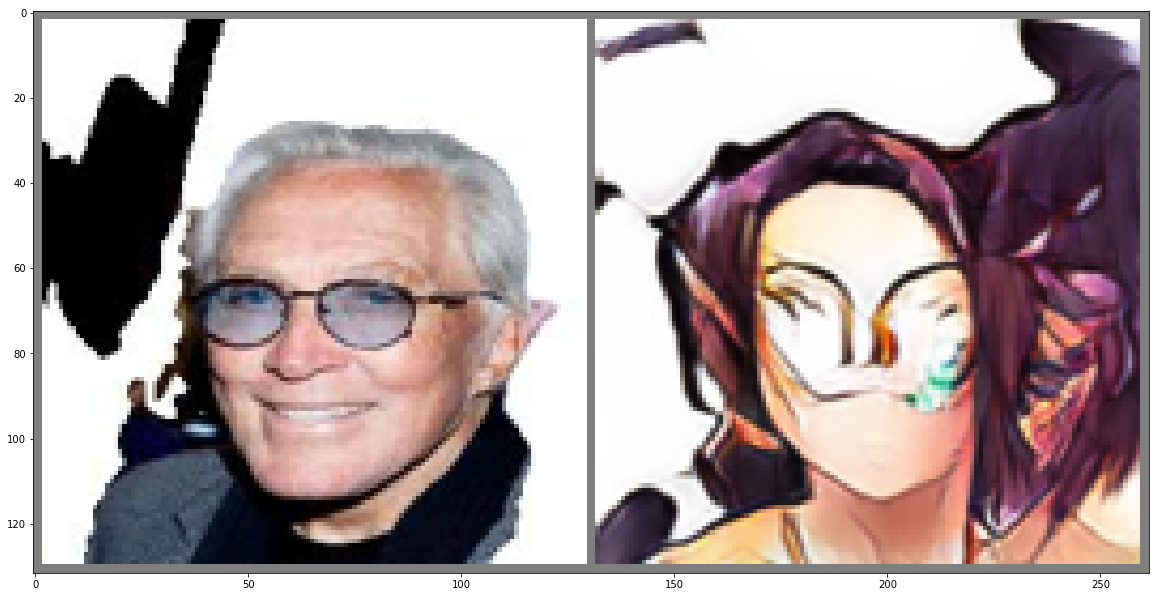

In [2447]:
show(torchvision.utils.make_grid([img_pre_128(B_),fake_A_3.data[0].cpu()]))

In [2350]:
opt.dataroot = '../datasets/getchu_celeba_aligned_cleaned_v1/'
phase = 'train'
B_celeba_path = glob.glob(os.path.join(opt.dataroot,phase+'B/*'))
A_path = glob.glob(os.path.join(opt.dataroot,phase+'A/*'))

In [2669]:
cropped_root = '/data2/minjunli/img_align_celeba/'
blur_root = '/data2/minjunli/masked_blur/'
B_mat_path = glob.glob('/data2/minjunli/B/*')

In [2431]:
B_p

'/data2/minjunli/B/014193.jpg'

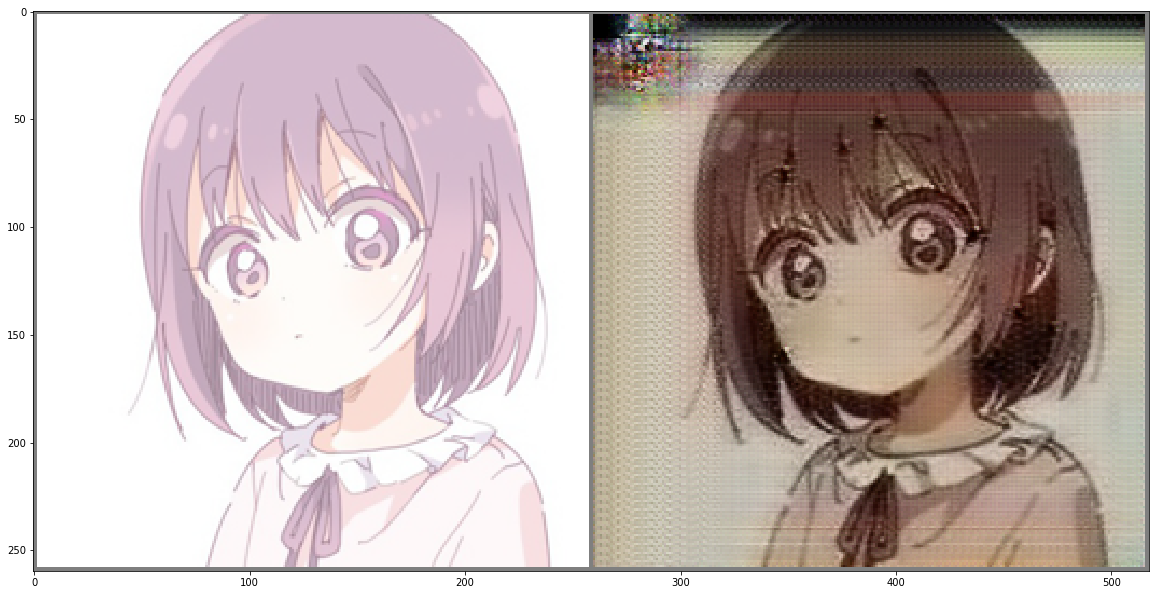

In [331]:
A_p = random.choice(A_path)
# A_p = './datasets/horse2zebra/trainA/n02381460_4804.jpg'
A_ = Image.open(A_p).convert('RGB')
fake_B_1 = test_img(A_, net_1['A'], img_pre_256, 256)
show(torchvision.utils.make_grid([img_show_256(A_),fake_B_1.data[0].cpu()]))

CityScape
===

In [ ]:
opt.dataroot = './datasets/cityscapes/'
phase = 'train'
B_path = glob.glob(os.path.join(opt.dataroot,phase+'B/*'))
A_path = glob.glob(os.path.join(opt.dataroot,phase+'A/*'))
AB_path = glob.glob(os.path.join(opt.dataroot,phase+'/*'))

stack = get_stack_nets('../trans/cityscapes_cyclegan_stack/')
net_1 = get_nets('../trans/cityscapes_cyclegan/')
net_2 = get_nets('./checkpoints/cityscapes_gp/')

In [ ]:
AB_ = Image.open(random.choice(AB_path)).convert('RGB')
A_ = AB_.crop((0, 0, 256, 256))
B_ = AB_.crop((256, 0, 512, 256))

In [ ]:
# B_p = random.choice(B_path)
# B_ = Image.open(B_p).convert('RGB')
fake_A_1 = test_img(B_, net_1['B'], img_pre, 256)
fake_A_2 = test_img(B_, net_2['B'], img_pre, 256)
fake_A_pre = stack['B_pre'].forward(to_input(B_, img_pre, 256))
fake_A_stack = stack['B'].forward(stack['B_pre'].forward(to_input(B_, img_pre, 256)))
show(torchvision.utils.make_grid([img_show_256(B_),fake_A_1.data[0].cpu(),fake_A_2.data[0].cpu(),fake_A_stack.data[0].cpu()]))

In [ ]:
# A_p = random.choice(A_path)
# A_ = Image.open(A_p).convert('RGB')
fake_B_1 = test_img(A_, net_1['A'], img_pre, 256)
fake_B_2 = test_img(A_, net_2['A'], img_pre, 256)
fake_B_pre = stack['A_pre'].forward(to_input(A_, img_pre, 256))
fake_B_stack = stack['A'].forward(stack['A_pre'].forward(to_input(A_, img_pre, 256)))
show(torchvision.utils.make_grid([img_show_256(A_),fake_B_1.data[0].cpu(),fake_B_2.data[0].cpu(),fake_B_stack.data[0].cpu()]))

In [ ]:
from scipy.misc import imresize

y = np.array(A_)
a_1 = util.tensor2im(fake_A_1.data.cpu())
a_2 = util.tensor2im(fake_A_2.data.cpu())
y_low = imresize(np.array(B_), (128,128))
a_pre = util.tensor2im(fake_A_pre.data.cpu())
a_stack = util.tensor2im(fake_A_stack.data.cpu())

In [ ]:
((y - a_1)**2).sum()/a_1.size,  ((y - a_2)**2).sum()/a_1.size, ((y_low - a_pre)**2).sum() / a_pre.size, ((y - a_stack)**2).sum()/a_1.size

In [ ]:
from scipy.misc import imresize

y = np.array(B_)
a_1 = util.tensor2im(fake_B_1.data.cpu())
a_2 = util.tensor2im(fake_B_2.data.cpu())
y_low = imresize(np.array(B_), (128,128))
a_pre = util.tensor2im(fake_B_pre.data.cpu())
a_stack = util.tensor2im(fake_B_stack.data.cpu())

In [ ]:
((y - a_1)**2).sum()/a_1.size,  ((y - a_2)**2).sum()/a_1.size, ((y_low - a_pre)**2).sum() / a_pre.size, ((y - a_stack)**2).sum()/a_1.size